# Lab

In [174]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)
from sklearn.model_selection import train_test_split

# New imports

from functools import partial
from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm

## The validation set approach

In [2]:
Auto = load_data('Auto')
Auto_train, Auto_valid = train_test_split(Auto,
                                          test_size=196,
                                          random_state=0)

In [3]:
hp_mm = MS(['horsepower'])
X_train = hp_mm.fit_transform(Auto_train)
y_train = Auto_train['mpg']
model = sm.OLS(y_train, X_train)
results = model.fit()

In [4]:
X_test = Auto_valid['horsepower'].to_frame()
X_test.insert(column='intercept', loc=0, value=1)
y_test = Auto_valid['mpg']

y_pred = results.predict(X_test)

AE = y_test.values - y_pred.values
Sq_AE = AE ** 2
MSE = np.mean(Sq_AE)

In [5]:
def evalMSE(terms,
            response,
            train,
            test):
    
    mm = MS(terms)
    X_train = mm.fit_transform(train)
    y_train = train[response]

    X_test = mm.transform(test)
    y_test = test[response]
    results = sm.OLS(y_train, X_train).fit()
    test_pred = results.predict(X_test)
    return np.mean((y_test - test_pred)**2)

In [6]:
MSE = np.zeros(3)

for idx, degree in enumerate(range(1, 4)):
    MSE[idx] = evalMSE([poly('horsepower', degree)],
                       'mpg',
                       Auto_train,
                       Auto_valid)
MSE

array([23.61661707, 18.76303135, 18.79694163])

In [7]:
Auto = load_data('Auto')
Auto_train, Auto_valid = train_test_split(Auto,
                                          test_size=196,
                                          random_state=3)

MSE = np.zeros(3)

for idx, degree in enumerate(range(1, 4)):
    MSE[idx] = evalMSE([poly('horsepower', degree)],
                       'mpg',
                       Auto_train,
                       Auto_valid)
MSE

array([20.75540796, 16.94510676, 16.97437833])

## Cross-Validation

In [8]:
hp_model = sklearn_sm(sm.OLS,
                      MS(['horsepower']))
X, Y = Auto.drop(columns=['mpg']), Auto['mpg']
cv_results = cross_validate(hp_model,
                            X,
                            Y,
                            cv=Auto.shape[0])
cv_err = np.mean(cv_results['test_score'])
cv_err

24.23151351792922

In [9]:
cv_error = np.zeros(5)
H = np.array(Auto['horsepower'])
M = sklearn_sm(sm.OLS)

for i, d in enumerate(range(1, 6)):
    X = np.power.outer(H, np.arange(d+1))
    M_CV = cross_validate(M,
                          X,
                          Y,
                          cv=Auto.shape[0])
    cv_error[i] = np.mean(M_CV['test_score'])
cv_error

array([24.23151352, 19.24821312, 19.33498406, 19.42443029, 19.03320648])

In [10]:
# How np.power.outer works
test = [1, 5, 3, 2]
np.power.outer(test, np.arange(3+1))

array([[  1,   1,   1,   1],
       [  1,   5,  25, 125],
       [  1,   3,   9,  27],
       [  1,   2,   4,   8]])

In [11]:
cv_error = np.zeros(5)
cv = KFold(n_splits=10,
           shuffle=True,
           random_state=0)
for i, d in enumerate(range(1, 6)):
    X = np.power.outer(H, np.arange(d+1))
    M_CV = cross_validate(M,
                          X,
                          Y,
                          cv=cv)
    cv_error[i] = np.mean(M_CV['test_score'])
cv_error

array([24.20766449, 19.18533142, 19.27626666, 19.47848403, 19.13720065])

In [12]:
validation = ShuffleSplit(n_splits=1,
                          test_size=196,
                          random_state=0)
results = cross_validate(hp_model,
                         Auto.drop(['mpg'], axis=1),
                         Auto['mpg'],
                         cv=validation)
results['test_score']

array([23.61661707])

In [13]:
validation = ShuffleSplit(n_splits=10,
                          test_size=196,
                          random_state=0)
results = cross_validate(hp_model,
                         Auto.drop(['mpg'], axis=1),
                         Auto['mpg'],
                         cv=validation)
results['test_score'].mean(), results['test_score'].std()

(23.802232661034168, 1.4218450941091842)

Note that this standard deviation is not a valid estimate of the sam-
pling variability of the mean test score or the individual scores, since the
randomly-selected training samples overlap and hence introduce correla-
tions. But it does give an idea of the Monte Carlo variation incurred by
picking different random folds.

## The Bootstrap

### Estimating the accuracy of a statistic of interest

Note: the return in the fuction below is the formula 5.7 from the manual.

In [39]:
Portfolio = load_data('Portfolio')
def alpha_func(D, idx):
    cov_ = np.cov(D[['X', 'Y']].loc[idx], rowvar=False)
    return ((cov_[1,1] - cov_[0,1]) / 
            (cov_[0,0] + cov_[1,1] -2 * cov_[0,1]))

In [40]:
rng = np.random.default_rng(0)
alpha_func(Portfolio,
           rng.choice(100,
                      100,
                      replace=True))

0.6074452469619004

In [41]:
def boot_SE(func,
            D,
            n=None,
            B=1000,
            seed=0):
    rng = np.random.default_rng(0)
    first_, second_ = 0, 0
    n = n or D.shape[0]
    for _ in range(B):
        idx = rng.choice(D.index,
                         n,
                         replace=True)
        value = func(D, idx)
        first_ += value
        second_ += value**2
    return np.sqrt(second_ / B - (first_ / B)**2)
    # return np.sqrt(1/1000 * (second_ - (first_ / B))**2)

In [42]:
alpha_SE = boot_SE(alpha_func,
                   Portfolio,
                   B=1000,
                   seed=0)
alpha_SE

0.09118176521277699

### Estimating the Accuracy of a Linear Regression Model

In [43]:
def boot_OLS(model_matrix, response, D, idx):
    D_ = D.loc[idx]
    Y_ = D_[response]
    X_ = clone(model_matrix).fit_transform(D_)
    return sm.OLS(Y_, X_).fit().params

In [44]:
hp_func = partial(boot_OLS, MS(['horsepower']), 'mpg')

In [45]:
rng = np.random.default_rng(0)
np.array([hp_func(Auto,
                  rng.choice(392,
                             392,
                             replace=True)) for _ in range(10)])

array([[39.88064456, -0.1567849 ],
       [38.73298691, -0.14699495],
       [38.31734657, -0.14442683],
       [39.91446826, -0.15782234],
       [39.43349349, -0.15072702],
       [40.36629857, -0.15912217],
       [39.62334517, -0.15449117],
       [39.0580588 , -0.14952908],
       [38.66688437, -0.14521037],
       [39.64280792, -0.15555698]])

In [46]:
hp_se = boot_SE(hp_func,
                Auto,
                B=1000,
                seed=10)
hp_se

intercept     0.857854
horsepower    0.007458
dtype: float64

In [47]:
hp_model.fit(Auto, Auto['mpg'])
model_se = summarize(hp_model.results_)['std err']
model_se

intercept     0.717
horsepower    0.006
Name: std err, dtype: float64

In [48]:
quad_model = MS([poly('horsepower', 2, raw=True)])
quad_func = partial(boot_OLS,
                    quad_model,
                    'mpg')
boot_SE(quad_func, Auto, B=1000)

intercept                                  2.067840
poly(horsepower, degree=2, raw=True)[0]    0.033019
poly(horsepower, degree=2, raw=True)[1]    0.000120
dtype: float64

In [49]:
M = sm.OLS(Auto['mpg'],
           quad_model.fit_transform(Auto))
summarize(M.fit())['std err']

intercept                                  1.800
poly(horsepower, degree=2, raw=True)[0]    0.031
poly(horsepower, degree=2, raw=True)[1]    0.000
Name: std err, dtype: float64

# Exercises

1. Using basic statistical properties of the variance, as well as single-variable calculus, derive 5.6. In other words, prove that a given by 5.6 does indeed minimize Var(aX + (1 - a)Y).

   idk man... I guess its probably time to learn some math...

2. We will now derive the probability that a given observation is part of a bootstrap sample. Suppose that we obtain a bootstrap sample from a set of n observations.

   (a) What is the probability that the first bootstrap observation is not the jth observation from the original sample? Justify your answer.

   1 - 1/n

   (b) What is the probability that the second bootstrap observation is not the jth observation from the original sample?

   1 - 1/n

   (c) Argue that the probability that the jth observation is not in the bootstrap sample is (1 - 1/n)^n
   this is because the term ^n makes sure that we bla blah

   (d) When n = 5, what is the probability that the jth observation is in the bootstrap sample?
   PROBABILITY = 0.672

   (e) When n = 100, what is the probability that the jth observation is in the bootstrap sample?
   probability = 0.634

   (f) When n = 10,000, what is the probability that the jth observation is in the bootstrap sample?
    probability = 0.632

   (g) Create a plot that displays, for each integer value of n from 1 to 100,000, the probability that the jth observation is in the bootstrap sample. Comment on what you obdserve.

In [65]:
x = 100
(1 - 1/x)**x

0.3660323412732292

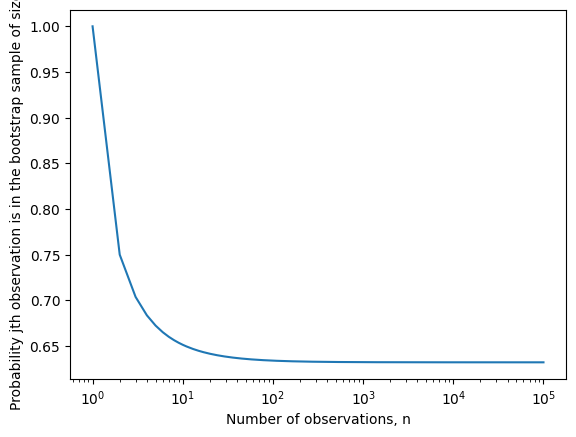

In [68]:
fig = plt.figure()
ax = fig.add_subplot()
x = np.arange(1, 100001)
y = 1 - (1 - (1/x))**x
ax.plot(x, y)

ax.set(xscale = "log", xlabel = "Number of observations, n", 
       ylabel = "Probability jth observation is in the bootstrap sample of size n");

(h) We will now investigate numerically the probability that a bootstrap sample of size n=100 contains the jth observation. Here j=4. We first create an array store with values that will subsequently be overwritten using the function np.empty(). We then repeatedly create bootstrap samples, and each time we record whether or not the fifth observation is contained in the bootstrap sample

In [165]:
rng = np.random.default_rng(10)
store = np.empty(10000)
for i in range(10000):
    store[i] = np.sum(rng.choice(100, 100, replace=True) == 4) > 0

np.mean(store)

0.6362

In [172]:
x=100
1 - (1 - (1/x))**x

# very close to this

0.6339676587267709

3. We now review k-fold cross-validation.

   (a) Explain how k-fold cross validation is implemented.
   We divide the data set into k parts of equal size. We use a fold as a validation set and the rest of the folds to fit the model. This way we estimate the MSE for the validation set.

   (b) What are the advantages and disadvantages of k-fold cross-validation relative to:

   i. The validation set approach?

   One advantage that k-fold cross-validation has over the validation set approach is that it makes use of every single observation, while the validation set approach leaves a fraction of the observations out of the model fit for testing purposes. A disadvantage is the computational aspect. Also, for the validation set approach, the test error is quite variable.

   ii. LOOCV?

   LOOCV is very computationally intensive as it fits a model for each observation. Another disadvantage is the variance-bias tradeoff, the LOOCV yields less accurate test error rates. LOOCV has higher variance but lower bias. LOOCV outputs are highly correlated with each other. Therefore, while the accuracy score estimates from k-fold cross-validation are more a bit biased than those from LOOCV, the reduction in variance often results in k-fold cross-validation giving more accurate estimates of the test accuracy score.

   4. Suppose that we use some statistical learning method to make a prediction for the response Y for a particular value of the predictor X. Carefully describe how we might estimate the standard deviation of our prediction.
  
    Assuming our dataset consists of independent observations (as opposed to something like time series data, in which observations that are close together in time are generally not independent and using a strategy such as a block bootstrap would be preferable), we can use the bootstrap to estimate the standard deviation of our prediction. Suppose our original data set had n observations. To perform the bootstrap for this situation, we randomly sample, with replacement, n observations from our original set of observations to use as a training set for our statistical learning method and obtain a bootstrap model M∗i. We then use the model M∗i to predict the response Y^∗i for the value of the predictor X. We repeat this procedure B times for some large value of B in order to produce B different bootstrap models M∗1,…,M∗B and B corresponding Y estimates, Y^∗1,…,Y^∗B. Once we have done this, we can use the formula for the sample standard deviation to compute an estimate of the standard deviation of our prediction.

## Applied

5. In chapter 4, we used logistic regression to predict the probability of default using income and balance on the Default data set. We will now estimate the test error of this logistic regression model using the validation set approach. Do not forget to set a random seed before beggining your analysis.

   (a) Fit a logistic regression model that uses income and balance to predict default.

In [279]:
np.random.seed(0)
Default = load_data('Default')
Default

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879
...,...,...,...,...
9995,No,No,711.555020,52992.378914
9996,No,No,757.962918,19660.721768
9997,No,No,845.411989,58636.156984
9998,No,No,1569.009053,36669.112365


In [280]:
X = 'income + balance'
y = 'default'

model = smf.glm(formula=f'{y} ~ 1 + {X}',
                data=Default,
                family=sm.families.Binomial()).fit()
summarize(model)

,coef,std err,z,P>|z|
Intercept,11.540500,0.435000,26.544,0.0
income,-0.000021,0.000005,-4.174,0.0
balance,-0.005600,0.000000,-24.835,0.0


    (b) Using the validation set approach, estimate the test error of this model. In order to do this, you must perform the following steps:

    i. Split the sample set into a training set and a validation set.

In [281]:
Train, Test = train_test_split(Default,
                               train_size=0.8)

    ii. Fit a multiple logistic regression model using only the training observations.

In [282]:
model_train = smf.glm(formula=f'{y} ~ 1 + {X}',
                      data=Train,
                      family=sm.families.Binomial()).fit()
summarize(model_train)

,coef,std err,z,P>|z|
Intercept,11.231600,0.477000,23.543,0.000
income,-0.000016,0.000006,-2.783,0.005
balance,-0.005500,0.000000,-22.133,0.000


    iii. Obtain a prediction of default status for each individual in the validation set by computing the posterior probability of default for that individual, and classifying the individual to the default category if the posterior probability is greater than 0.5.

In [283]:
X_features = ['income', 'balance']
Y_pred = np.where(model_train.predict(Test[X_features]) > 0.5,
                  'No',
                  'Yes')

    iv. Compute the validation set error, which is the fraction of the observations in the validation set that are misclassified.

In [284]:
1 - np.mean(Test['default'] == Y_pred)

0.028000000000000025

    (c) Repeat the process in (b) three times, using three different splits of the observation into a training set and a validation set. Comment on the results obtained.

In [285]:
for random_state in range(1, 10):
    Train, Test = train_test_split(Default,
                               train_size=0.8)
    model_train = smf.glm(formula=f'{y} ~ 1 + {X}',
                      data=Train,
                      family=sm.families.Binomial()).fit()
    X_features = ['income', 'balance']
    Y_pred = np.where(model_train.predict(Test[X_features]) > 0.5,
                      'No',
                      'Yes')
    print(f'For random state {random_state} a test error rate of', \
           f'{(1 - np.mean(Test["default"] == Y_pred))*100}%')

For random state 1 a test error rate of 2.6000000000000023%
For random state 2 a test error rate of 2.5499999999999967%
For random state 3 a test error rate of 2.649999999999997%
For random state 4 a test error rate of 2.400000000000002%
For random state 5 a test error rate of 2.2499999999999964%
For random state 6 a test error rate of 3.3499999999999974%
For random state 7 a test error rate of 2.300000000000002%
For random state 8 a test error rate of 3.0000000000000027%
For random state 9 a test error rate of 2.6000000000000023%




We see that the validation estimate of the test error rate can be variable, depending on precisely which observations are included in the training set and which observations are included in the validation set.

    (d) Now consider a logistic regression model that predicts the probability of default using income, balance and a dummy variable for student. Estimate the test error for this model using the validation set approach. Comment on whether or not including a dummy variable for student leads to a reduction in the test error rate.

In [300]:
dummies = pd.get_dummies(Default['student'],
                         prefix='student')
Default_dummies = (pd
                   .concat([Default, dummies],
                            axis='columns')
                   .drop(columns='student'))

In [301]:
Train, Test = train_test_split(Default_dummies,
                               train_size=0.8)

In [302]:
X_features = (Default_dummies
              .drop(columns='default')
              .columns)
X = ' + '.join(X_features)
model_train = smf.glm(formula=f'{y} ~ 1 + {X}',
                      data=Train,
                      family=sm.families.Binomial()).fit()
summarize(model_train)

,coef,std err,z,P>|z|
Intercept,7.441500,0.339000,21.946,0.000
balance,-0.005700,0.000000,-21.894,0.000
income,-0.000004,0.000009,-0.404,0.686
student_No,3.448600,0.241000,14.314,0.000
student_Yes,3.993000,0.186000,21.516,0.000


In [305]:
Y_pred = np.where(model_train.predict(Test[X_features]) > 0.5,
                  'No',
                  'Yes')
f'{(1 - np.mean(Test["default"] == Y_pred))*100}%'

'2.4499999999999966%'

It doesn’t seem that adding the “student” dummy variable leads to a reduction in the validation set estimate of the test error rate.

6. We continue to consider the use of a logistic regression model to predict the probability of default using income and balance on the DEfault data set. In particular, we will now compute estimates for the standard errors of the income and balance logistic regression coefficients in two different ways: (1) using the bootstrap, and (2) using the standard formula for computing the standard errors in the sm.GLM() function. Do not forget to set a random seed before beggining your analysis.

In [309]:
np.random.seed(0)

    (a) Using the summarize() and sm.GLM() functions, determine the estimated standard errors for the coefficients associated with income and balance in a multiple logistic regression model that uses both predictors.

In [313]:
X = 'income + balance'
y = 'default'

model = smf.glm(formula=f'{y} ~ 1 + {X}',
                data=Default,
                family=sm.families.Binomial()).fit()
summarize(model)['std err']

Intercept    0.435000
income       0.000005
balance      0.000000
Name: std err, dtype: float64

    (b) Write a function, boot_fn(), that takes an input the Default data set as well as an index of the observations, and that outputs the coefficient estimates for income and balance in the multiple logistic regression model.

In [381]:
def boot_fn(D, idx):
    D = D.loc[idx]
    X = 'income + balance'
    y = 'default'
    model = smf.glm(formula=f'{y} ~ 1 + {X}',
                    data=D,
                    family=sm.families.Binomial()).fit()
    return model.params

    (c) Following the bootstrap example in the lab, use your boot_fn() function to estimate the standard errors of the logistic regression coefficients for income and balance.

In [382]:
se = boot_SE(boot_fn,
             Default,
             B=1000,
             seed=10)
se

Intercept    0.435692
income       0.000005
balance      0.000230
dtype: float64

(d) Comment on the estimated standard errors obtained using the sm.GLM() function and using the bootstrap.

It seems like the sm.GLM() standard error estimates are underestimated. The standard errors computed by the bootstrap are higher. The standard formulas of the standard errors of the coefficients rely on certain assumptions that are not necesarily met here, but the bootstrap standard error estimates do not rely on such assumptions, hence the highe accuracy.

7. In sections 5.1.2 and 5.1.3, we saw that the cross_validate() function can be used in order to compute the LOOCV test error estimate. Alternatively, one could compute those quantities using just sm.GLM() and the predict() method of the fitted model within a for loop. You will now take this approach in order to compute the LOOCV error for a simple logistic regression model on the Weekly data set. Recall that in the context of classification problems, the LOOCV error is given in 5.4.

   (a) Fit a logistic regression model that predicts Direction using Lag1 and Lag2.

In [407]:
Weekly = load_data('Weekly')
Weekly.Direction = np.where(Weekly.Direction == 'Down',
                            0,
                            1)
Weekly.head(2)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,0
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,0


In [408]:
X = ['Lag1', 'Lag2']
X_formula = ' + '.join(X)

y = 'Direction'

model = smf.glm(formula=f'{y} ~ 1 + {X_formula}',
                data=Weekly,
                family=sm.families.Binomial()).fit()

(b) Fit a logistic regression model that predicts Direction using Lag1 and Lag2 using all but first observation.

In [409]:
X = ['Lag1', 'Lag2']
X_formula = ' + '.join(X)

y = 'Direction'

model = smf.glm(formula=f'{y} ~ 1 + {X_formula}',
                data=Weekly.iloc[1:],
                family=sm.families.Binomial()).fit()

(c) Use the model from (b) to predict the direction of the first observation. You can do this by predicting that the first observation will go up if P(Direction = 'Up'|Lag1, Lag2) > 0.5. Was this observation correctly classified?

In [410]:
model.predict(Weekly)[0]

0.5713923205204429

Seems like the model predicts that it would go up.

(d) Write a for loop from i = 1 to i = n, where n is the number of obdservation in the data set, that performs each of the following steps:

    i. Fit a logistic regression model using all but the ith observation to predict Direction using Lag1 and Lag2

In [454]:
def LOOCV_GLM(D, idx):
    D = D.drop(idx)
    X = ['Lag1', 'Lag2']
    X_formula = ' + '.join(X)
    y = 'Direction'
    model = smf.glm(formula=f'{y} ~ 1 + {X_formula}',
                    data=D,
                    family=sm.families.Binomial()).fit()
    return model

    ii. Compute the posterior probability of the market moving up for the ith observation.

In [455]:
def posterior_probability(model, D, idx):
    return model.predict(D.iloc[idx]).values

    iii. Use the posterior probability for the ith obdservation in order to predict whether or not the market moves up.

In [456]:
def probability_bool(probability):
    return 1 if probability > 0.5 \
                else 0

iv. Determine whether or not an error was made in predicting the direction for the ith observation. If an error was made, then indicate this as a 1, and otherwise indicate it as a 0.

In [457]:
def probability_accuracy(true_bool, pred_bool):
    return 0 if true_bool == pred_bool \
             else 1

In [482]:
def LOOCV(D):
    n = D.shape[0]
    y = D.Direction
    pred = np.empty(n)
    for idx in range(0, n):
        model = LOOCV_GLM(D, idx)
        pred[idx-1] = probability_accuracy(y[idx],
                                    probability_bool(
                                       posterior_probability(model, D, idx)))
    return pred

In [484]:
pred = LOOCV(Weekly)
mean = pred.mean()

In [485]:
'The test error is', mean

('The test error is', 0.44995408631772266)

8. We will now perform cross-validation on a simulated data set.

   (a) Generate a simulated data as follows:

In [615]:
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

In this data set, what is n and what is p? Write out the model used to generate the data in equation form.

n = 100

p = 1

Y=X−2X2+ε.

(b) Create a scatterplot of X against Y. Comment on what you find.

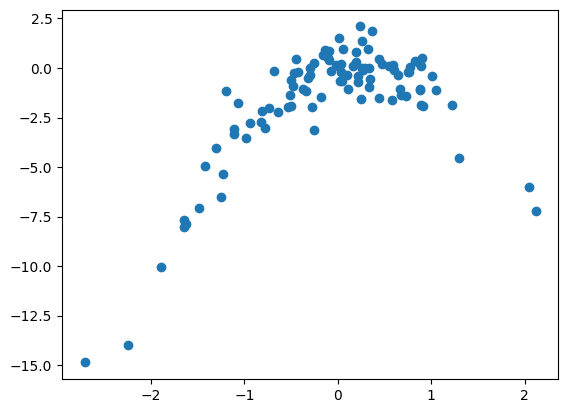

In [616]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(x, y)

Looks like a quadratic function.

In [617]:
df = pd.DataFrame({'y':y,
                   'x':x})

(c) Set a random seed, and then compute the LOOCV errors that result from fitting the following four models using least squares:

    i. Y = B0 + B1X + e

In [618]:
np.random.seed(0)
model = sklearn_sm(sm.OLS)
cv_results = cross_validate(model, x, y, cv=df.shape[0])
cv_err = np.mean(cv_results['test_score'])
cv_err

8.868921429341826

ii. Y = B0 + B1X + B2X^2 + e

In [619]:
X = df['x'].values
y = df['y'].values
M = sklearn_sm(sm.OLS)
X = np.power.outer(X, np.arange(3))
M_CV = cross_validate(M,
                      X,
                      y,
                      cv=df.shape[0])
np.mean(M_CV['test_score'])

1.1229368563419688

iii. Y = B0 + B1X + B2X^2 + B2X^3 + e


In [620]:
X = df['x'].values
y = df['y'].values
M = sklearn_sm(sm.OLS)
X = np.power.outer(X, np.arange(4))
M_CV = cross_validate(M,
                      X,
                      y,
                      cv=df.shape[0])
np.mean(M_CV['test_score'])

1.3017965489358871

iv. Y = B0 + B1X + B2X^2 + B2X^3 + B2X^4 + e

In [621]:
X = df['x'].values
y = df['y'].values
M = sklearn_sm(sm.OLS)
X = np.power.outer(X, np.arange(5))
M_CV = cross_validate(M,
                      X,
                      y,
                      cv=df.shape[0])
np.mean(M_CV['test_score'])

1.3323942694179303

(d) Repeat (c) using another random seed, and report your results. Are your results the same as what you got in (c)? Why?

I will not repeat the above with another seed because yes, the results will be the same. This is because randomness doesnt impact LOOCV since we fit a model for every single observation anyway.

In [657]:
np.random.seed(999)
X = df['x'].values
y = df['y'].values
M = sklearn_sm(sm.OLS)
X = np.power.outer(X, np.arange(5))
M_CV = cross_validate(M,
                      X,
                      y,
                      cv=df.shape[0])
np.mean(M_CV['test_score'])

1.3323942694179303

(e) Which of the models in (c) had the smallest LOOCV error? Is this what you expected? Explain your answer.

The quadratic model had the least LOOCV error and it is what I expected since the scatterplot distribution indicated a quadratic graph.

(f) Comment on the statistical significance of the coefficient estimates that results from fitting each of the models in (c) using least squares. Do these results agree with conclusions drawn based on the cross-validation results?

In [658]:
for power in range(2, 5):
    df[f'x**{power}'] = df['x'] ** power

In [659]:
for i in range(2, 6):
    X = sm.add_constant(df.iloc[:, 1:i])
    model = sm.OLS(df['y'],
                   X).fit()
    display(summarize(model))

,coef,std err,t,P>|t|
const,-1.4650,0.247,-5.937,0.0
x,1.9494,0.289,6.752,0.0


,coef,std err,t,P>|t|
const,-0.0728,0.119,-0.611,0.543
x,0.9663,0.126,7.647,0.000
x**2,-2.0047,0.091,-22.072,0.000


,coef,std err,t,P>|t|
const,-0.0572,0.120,-0.477,0.635
x,1.1146,0.187,5.945,0.000
x**2,-2.0471,0.099,-20.673,0.000
x**3,-0.0643,0.060,-1.070,0.287


,coef,std err,t,P>|t|
const,0.1008,0.136,0.743,0.460
x,0.9050,0.205,4.423,0.000
x**2,-2.5059,0.221,-11.336,0.000
x**3,0.0338,0.073,0.466,0.642
x**4,0.1042,0.045,2.309,0.023


They do agree! We can clearly see from the last 2 models that the cubic and quartic terms are not statistically significant.

9. We will now consider the Boston housing data set, from the ISLP library.

    (a) Based on this data set, provide an estimate for the population mean of medv. Call this estimate μ̂.

In [696]:
Boston = load_data('Boston')

In [697]:
medv = Boston['medv']
medv_mean = medv.mean()

    (b) Provide an estimate of the standard error of μ̂. Interpret this result.

In [698]:
se = medv.std()/(medv.shape[0] ** 0.5)
se

0.40886114749753505

The Standard Error ("Std Err" or "SE"), is an indication of the reliability of the mean. A small SE is an indication that the sample mean is a more accurate reflection of the actual population mean. A larger sample size will normally result in a smaller SE (while SD is not directly affected by sample size).

    (c) Now estimate the standard error of μ̂ using the bootstrap. How does this compare to your answer from (b)?

In [699]:
def bootstrap(x, Boot, func):
    resampled_stat = []

    for k in range(Boot):
        idx = np.random.choice(np.arange(0, len(x)),
                               x.shape[0],
                               replace=True)
        sample = x[idx]
        statistic = func(sample)
        resampled_stat.append(statistic)
    return resampled_stat

(d) Based on your bootstrap estimate from (c), provide a 95% confidence interval from the mean of medv. Compare it to the results obtained by using Boston['medv'].std() and the two standard error rule 3.9.

In [705]:
np.random.seed(0)

medv_bs = bootstrap(medv.values, 1000, np.mean)
medv_bs_se = np.std(medv_bs)
print('Bootstrap SE:', medv_bs_se, '| Sample SE:', se)

Bootstrap SE: 0.41163337514478704 | Sample SE: 0.40886114749753505


In [720]:
medv_bs_mean = np.mean(medv_bs)
lower_bound = medv_bs_mean - 2*medv_bs_se
upper_bound = medv_bs_mean + 2*medv_bs_se
print(f'Bootstrap 95% confidence interval: [{lower_bound}, {upper_bound}]')

Bootstrap 95% confidence interval: [21.69358008765509, 23.340113588234235]


In [721]:
lower_bound, upper_bound = medv_mean - 2*se, medv_mean + 2*se
print(f'Population 95% confidence interval: [{lower_bound}, {upper_bound}]')

Population 95% confidence interval: [21.715084029115605, 23.35052861910575]


(e) Based on this data set, provide an estimate, μ̂med, for the median
value of medv in the population.

In [722]:
medv_median = medv.median()
medv_median

21.2

(f) We now would like to estimate the standard error of μ̂med. Unfortunately, there is no simple formula for computing the standard error of the median. Instead, estimate the standard error of the median using the bootstrap. Comment on your finding.

In [723]:
np.random.seed(0)

medv_bs = bootstrap(medv.values, 1000, np.median)
medv_bs_se = np.std(medv_bs)
print('Bootstrap SE:', medv_bs_se)

Bootstrap SE: 0.3950537147021905


The SE seems to be smaller than the mean counterpart (not like that says anything relevant).

(g) Based on this data set, provide an estimate for the tenth percentile of medv in Boston census tracts. Call this quantity μ̂0.1.

In [750]:
perc10 = np.percentile(medv, 10)
perc10

12.75

(h) Use the bootstrap to estimate the standard error of μ̂0.1. Comment on your finding.

In [753]:
np.random.seed(0)
func = partial(np.percentile, q=10)
medv_bs_10perc = bootstrap(medv.values, 1000, func)
print('Bootstrap 10perc:', np.std(medv_bs_10perc))

Bootstrap 10perc: 0.49966926811642115
